## On change la loss function --> (multinomial) CrossEntropy loss

## output = multinomial sample

## Passage à une architecture convolutionnelle

Ajouts/modifs :
  * simplification de l'architecture (seule l'image blanchie est en entrée)
  * dans le roll : supression des régions hors image (np.pad) 


In [9]:
N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 24, 16, 2, 256, 256, 1.21 #1.41 #1.25 #
#N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 12, 8, 2, 256, 256, 1.41
verbose = 1
OFFSET_STD = 15
OFFSET_MAX = 30

## Pierre's stuff

### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [21]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=1, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                y = N_Y/2 + r * \
                    np.sin((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()


    return retina

In [27]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(24, 16, 65536)


In [28]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(384, 65536)


In [29]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(65536, 384)


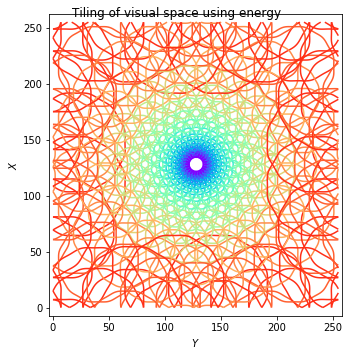

In [30]:
energy = colliculus ** 2
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

## Images dataset

In [31]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

In [32]:
np.random.rand() > 0.5

True

In [92]:
#im = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

class Transform(object):
    """Rescale the image through LogGabors

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, test = False, tensor = False):
        #assert isinstance(output_size, (int, tuple))
        #self.output_size = output_size
        self.test = test
        self.tensor = tensor

    def __call__(self, sample):
        image, image_white, fixmap = sample['image'], sample['image_white'], sample['fixation']
        (nb_l, nb_col) = image.shape
        
        #i_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
        #j_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
        
        '''if np.random.rand() > 0.5:
            image_white = np.fliplr(image_white)
            image = np.fliplr(image)
            fixmap = np.fliplr(fixmap)'''
        
        if not self.test:
            m = fixmap/sum(fixmap.flatten())
            m = m.flatten()
            m_mult = np.random.multinomial(1, m).reshape(256, 256)
            coord = np.where(m_mult == 1)
            i_offset = 127 - coord[0][0]
            j_offset = 127 - coord[1][0]
        else:
            i_offset = 0
            j_offset = 0
        
        '''i_offset = 0
        j_offset = -50'''
        
        image_white = np.roll(image_white, i_offset, axis=0)
        image_white = np.roll(image_white, j_offset, axis=1)  
        mean_white = np.mean(image_white.flatten())
        std_white = np.std(image_white.flatten())
        
        image = np.roll(image, i_offset, axis=0)
        image = np.roll(image, j_offset, axis=1)
        mean_im = np.mean(image.flatten())
        std_im = np.std(image.flatten())
        
        fixmap = np.roll(fixmap, i_offset, axis=0)
        fixmap = np.roll(fixmap, j_offset, axis=1)    
        
        if i_offset > 0 :
            image_white[:i_offset, :] = mean_white + std_white * np.random.randn(i_offset, nb_col) #127
            image[:i_offset, :] = mean_im + std_im * np.random.randn(i_offset, nb_col) #127
            fixmap[:i_offset, :] = 0
        elif i_offset < 0:
            image_white[i_offset:, :] = mean_white + std_white * np.random.randn(-i_offset, nb_col) #127
            image[i_offset:, :] = mean_im + std_im * np.random.randn(-i_offset, nb_col) #127
            fixmap[i_offset:, :] = 0     
        
        if j_offset > 0 :
            image_white[:,:j_offset] = mean_white + std_white * np.random.randn(nb_l, j_offset) #127
            image[:,:j_offset] = mean_im + std_im * np.random.randn(nb_l, j_offset) #127
            fixmap[:,:j_offset] = 0
        elif j_offset < 0:
            image_white[:,j_offset:] = mean_white + std_white * np.random.randn(nb_l, -j_offset) 
            image[:,j_offset:] = mean_im + std_im * np.random.randn(nb_l, -j_offset) 
            fixmap[:,j_offset:] = 0
        
        image_white = (image_white - mean_white) / std_white
        image = (image - mean_im) / std_im
        
        '''plt.figure()    
        plt.imshow(image_white, cmap = 'gray')
        plt.figure()    
        plt.imshow(fixmap, cmap = 'gray')'''
        
        image_retina = retina_vector @ np.ravel(image_white)
        image_retina /= np.std(image_retina)
        
        image_colliculus = colliculus_vector @ np.ravel(image)
        #image_colliculus -= np.mean(image_colliculus)
        image_colliculus /= np.std(image_colliculus)
        
        fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)
        fixmap_colliculus = fixmap_colliculus/np.sum(fixmap_colliculus)
        
        if not self.test:
            m_coll = fixmap_colliculus/sum(fixmap_colliculus)
            m_coll_mult = np.random.multinomial(100, m_coll)
            #m_coll_mult[np.where(m_coll_mult > 1)] = 1
            m_coll_mult = np.array(m_coll_mult)/np.sum(m_coll_mult)
        
        if self.tensor:
            image_retina = image_retina.reshape(N_theta, N_azimuth, N_eccentricity, N_phase)
            slice1 = image_retina[N_theta - 1,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
            slice2 = image_retina[0,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
            image_retina = np.concatenate ((slice1, image_retina, slice2), axis = 0)
            image_retina = np.transpose(image_retina,(3,0,1,2))
            image_colliculus = image_colliculus.reshape(1,N_azimuth, N_eccentricity)
            '''if not self.test:
                m_coll_mult = m_coll_mult.reshape(1, N_azimuth, N_eccentricity)
            else:
                fixmap_colliculus = fixmap_colliculus.reshape(N_azimuth, N_eccentricity)'''
                
        if self.test:
            return {'image': image_colliculus, 'image_white': image_retina, 'fixation': fixmap_colliculus}
        else:
            return {'image': image_colliculus, 'image_white': image_retina, 'fixation': m_coll_mult}   
        
        #r 

In [67]:
## test

In [93]:
class ImageDataset(data.Dataset):
    """image dataset."""

    def __init__(self, imdir, imdir_white, fixdir, transform=None, index = None):
        """
        Args:
            imdir (string): Path to the image folder
            fixdir (string): Path to the fixation maps folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imdir = imdir
        self.fixdir = fixdir
        self.imdir_white = imdir_white
        if index is None :
            print('OK')
            self.image_names=os.listdir(imdir)
            self.fix_names=os.listdir(fixdir)
        else:
            self.image_names=np.array(os.listdir(imdir))[index]
            self.fix_names=np.array(os.listdir(fixdir))[index]
        self.transform = transform # we do not use transforms
        #self.data_loader=data.DataLoader(self,batch_size=batch_size) : did not work
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image=np.load(os.path.join(self.imdir,self.image_names[idx]))
        image_white=np.load(os.path.join(self.imdir_white,self.image_names[idx]))
        fix_map=np.load(os.path.join(self.fixdir,self.fix_names[idx]))/255 # to transform between 0 and 1 (for the BCELoss to work)

        sample = {'image': image, 'image_white': image_white, 'fixation': fix_map}

        if self.transform:
            sample = self.transform(sample)
        
        return sample


#### Hyperparameters

In [62]:
minibatch_size = 25  # quantity of examples that'll be processed
lr = 1e-4 #0.05

n_hidden1_white = 500 #2000 #800 #
n_hidden1 = 500 #200 #
n_hidden2 = 100 #50 #
n_hidden3 = 10  #10 #50
n_hidden4 = 500 #50

print('n_hidden1', n_hidden1, ' / n_hidden2', n_hidden2)
verbose = 1
train = True

n_hidden1 500  / n_hidden2 100


In [63]:
torch.cuda.is_available()

False

In [64]:
do_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [65]:
transform = Transform(tensor = True)
transform_test = Transform(tensor = True, test = True)

image_dir = imdir #'GLOBAL_IMAGES_ALL'
fix_dir = fixdir #'GLOBAL_FIXATIONMAPS_ALL'

'''image_names=os.listdir(image_dir)
print (len(image_names))
fix_names=os.listdir(fix_dir)
print (len(fix_names))
for i in range(len(image_names)):
    if image_names[i][:7] != fix_names[i][:7]:
        print(image_names[i], fix_names[i])'''

n = len(os.listdir(image_dir))
index = np.arange(n)
np.random.shuffle(index)
print(index)
index_train = index[:800]
index_test = index[800:]

train_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform, index = index_train)
train_loader = data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True, num_workers=4)

test_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform_test, index = index_test)
test_loader = data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=4)

[ 18 799 241 ...,   8 625  14]


In [58]:
len(train_dataset)

800

In [59]:
'''for batch_idx, batch in enumerate(train_loader):
    print (batch_idx)'''

'for batch_idx, batch in enumerate(train_loader):\n    print (batch_idx)'

In [60]:
N_azimuth, N_eccentricity, N_theta

(24, 16, 6)

#### Network

In [7]:
BIAS = False #True

class Net(torch.nn.Module):
    
    def __init__(self, n_hidden1, n_hidden1_white, n_hidden2, n_hidden3, n_hidden4, n_output):
        super(Net, self).__init__()
        ## White
        self.conv1_white = nn.Conv3d(2, 16, 3, bias = BIAS, stride=1, padding=1)
        self.conv2_white = nn.Conv3d(16, 64, 3, bias = BIAS, stride=1, padding=1)
        self.conv3_white = nn.Conv3d(64, 256, 3, bias = BIAS, stride=1, padding=1)
        self.pool_white = nn.MaxPool3d(2, stride=2)
        # taille 256 *  3 (az) * 2 (ecc) * 1 (thet)
        self.hidden1_white = torch.nn.Linear(256 * 3 * 2, n_hidden1_white, bias = BIAS)
        self.hidden2_white = torch.nn.Linear(n_hidden1_white, n_hidden2, bias = BIAS)
        
        ## Grey
        self.conv1_grey = nn.Conv2d(1, 8, 2, bias = BIAS, stride=2, padding=0)
        self.conv2_grey = nn.Conv2d(8, 16, 2, bias = BIAS, stride=2, padding=0)
        self.conv3_grey = nn.Conv2d(16, 32, 2, bias = BIAS, stride=2, padding=0)
        # taille 32 * 3 * 2
        self.hidden1 = torch.nn.Linear(32 * 3 * 2, n_hidden1, bias = BIAS)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2, bias = BIAS)
        
        self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3, bias = BIAS)
        self.hidden4 = torch.nn.Linear(n_hidden3, n_hidden4, bias = True)
        self.predict = torch.nn.Linear(n_hidden4, n_output, bias = True)
        #self.dropout = nn.Dropout(p = 0.5) 
        
    def forward(self, image, image_white):
        
        # white
        data_white = F.relu(self.pool_white(self.conv1_white(image_white)))
        data_white = F.relu(self.pool_white(self.conv2_white(data_white)))
        data_white = F.relu(self.pool_white(self.conv3_white(data_white)))
        data_white = data_white.view(-1, 256 * 3 * 2)
        data_white = F.relu(self.hidden1_white(data_white))
        
        # gray
        '''data = F.relu(self.conv1_grey(image))
        data = F.relu(self.conv2_grey(data))
        data = F.relu(self.conv3_grey(data))
        data = data.view(-1, 32 * 3 * 2)
        data = F.relu(self.hidden1(data))'''
        
        # fusion
        data = F.relu(self.hidden2_white(data_white)) #+self.hidden2(data) #+ 
        data = F.dropout(data, p = .5) #self.dropout)
        #data = F.relu(self.hidden3(data))
        data = self.hidden3(data)
        
        # Out
        data = F.relu(self.hidden4(data))
        data =  self.predict(data)
        return data
    
    '''def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features'''

In [8]:
net = Net(n_hidden1=n_hidden1,\
          n_hidden1_white=n_hidden1_white,\
          n_hidden2=n_hidden2,\
          n_hidden3=n_hidden3,\
          n_hidden4=n_hidden4,\
          n_output=N_azimuth*N_eccentricity)

NameError: name 'N_azimuth' is not defined

In [66]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [79]:
#loss_func = torch.nn.BCEWithLogitsLoss()
def loss_func(pred, soft_targets):
    # cross entropy
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [67]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = N_azimuth * N_eccentricity, \
          verbose=1):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
       
        log_image_batch = batch['image'].float()
        log_image_batch_white = batch['image_white'].float()
        log_fixmap_batch = batch['fixation'].float()
        
        prediction = net(log_image_batch, log_image_batch_white)
        loss = loss_func(prediction, log_fixmap_batch) 

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx * minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
    return net


In [68]:
def test(net, minibatch_size, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity):
    #for batch_idx, (data, label) in enumerate(test_loader):
    batch = next(iter(test_loader))
    batch_size = len(batch)
    
    '''log_image_batch = np.zeros((batch_size, 1, vsize))
    log_fixmap_batch = np.zeros((batch_size, 1, asize))
    
    for idx in range(batch_size):
        log_image_batch[idx, 0, :], log_fixmap_batch[idx, 0, :] = couples(batch['image'][idx, :, :], batch['fixation'][idx, :, :])
        #input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :], i_offset, j_offset)
        #target[idx, :] = a_data[idx, 0, :]'''


    prediction = net(batch['image'].float(), batch['image_white'].float())
    loss = loss_func(prediction, batch['fixation'].float())

    return loss.data.numpy()


In [75]:
'''REDRAW = True
CONTINUE = False
EPOCHS = 1
FIC_NAME = '2018-11-21-Malek recap.npy'

def entraine():
    for epoch in range(EPOCHS) :#range(1, 100):
        print(epoch)
        train(net, minibatch_size)
        Accuracy = test(net, minibatch_size)
        print('Test set: Final Accuracy: {:.3f}'.format(Accuracy * 1.)) # print que le pourcentage de réussite final
        torch.save(net, FIC_NAME)  

if not os.path.exists(FIC_NAME) or REDRAW:
    print('OK')
    entraine()    
else:
    net = torch.load(FIC_NAME)   
    if CONTINUE:
        entraine()'''
        
FIC_NAME = '2018-12-10-Malek recap.npy'
EPOCHS = 1 #50

if True : #not os.path.exists(FIC_NAME):
    for epoch in range(EPOCHS) :#range(1, 100):
        print(epoch)
        train(net, minibatch_size)
        Accuracy = test(net, minibatch_size)
        print('Test set: Final Accuracy: {:.3f}'.format(Accuracy * 1.)) # print que le pourcentage de réussite final
        torch.save(net, FIC_NAME)    
else:
    net = torch.load(FIC_NAME)    

0
Starting training...
[0/800] Loss: 5.953465938568115 Time: 0.47 mn


Process Process-91:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-29-c97f2210d95f>", line 36, in __getitem__
    sample = self.transform(sample)
  File "<ipython-input-26-d2f8f8f62879>", line 82, in __call__
    image_colliculus = colliculus_vector @ np.ravel(image)
KeyboardInterrupt
Process Process-92:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-1fd4f7102302>", line 28, in <module>
    train(net, minibatch_size)
  File "<ipython-input-73-42bc0e018b4d>", line 7, in train
    for batch_idx, batch in enumerate(train_loader):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = sel

KeyboardInterrupt: 

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.M

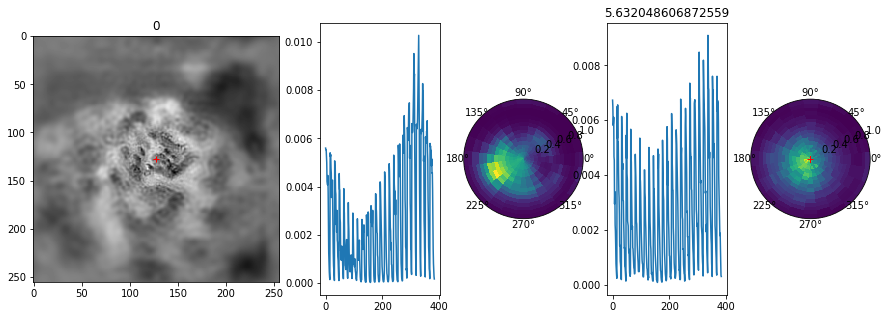

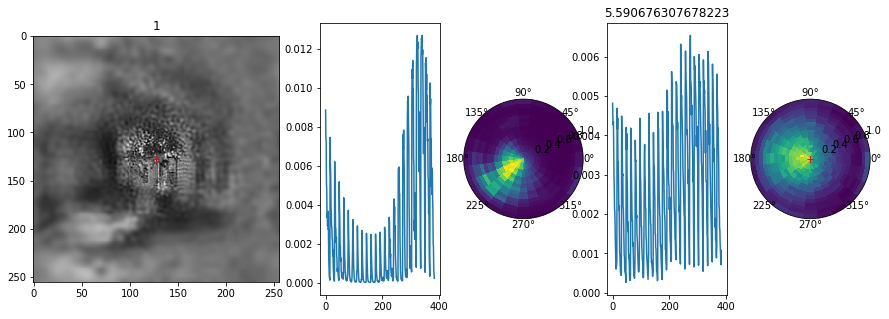

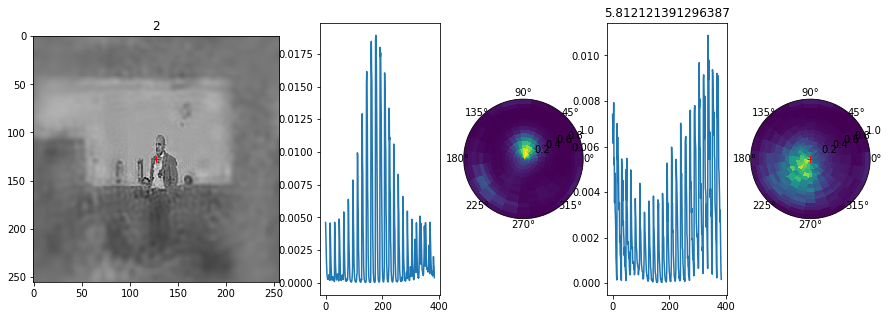

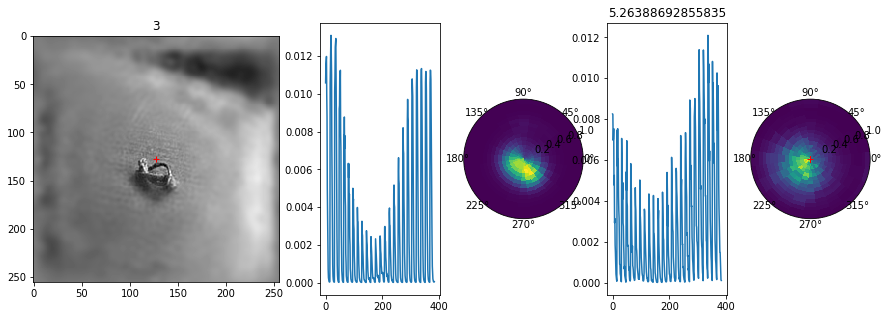

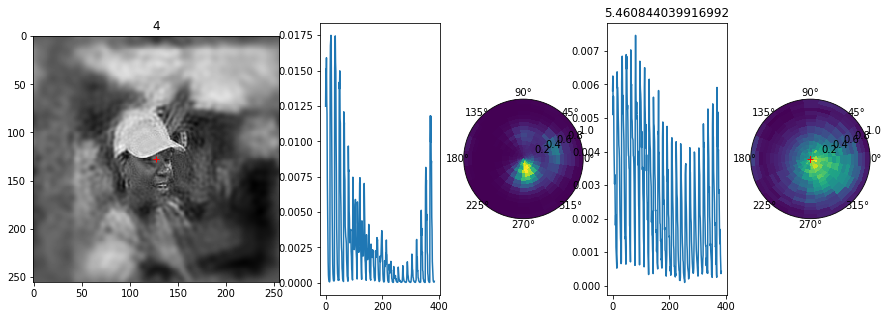

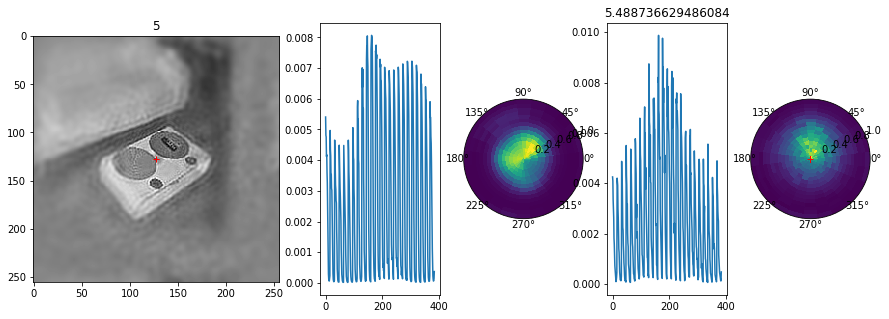

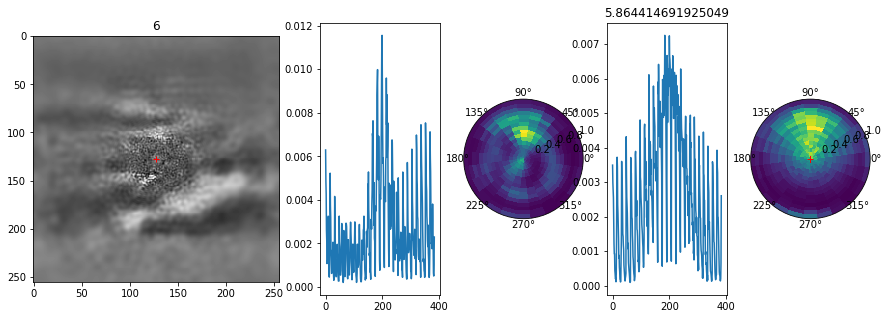

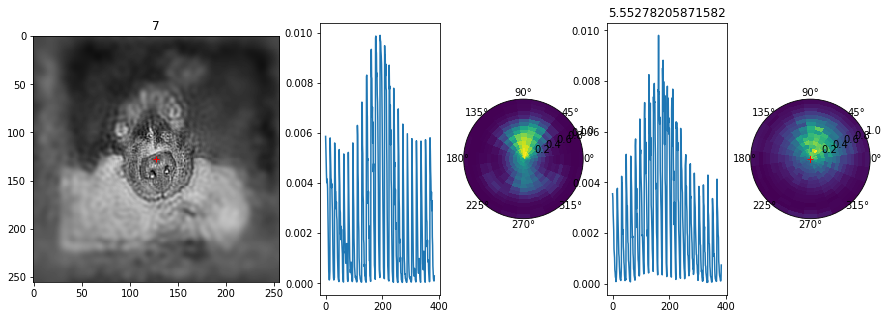

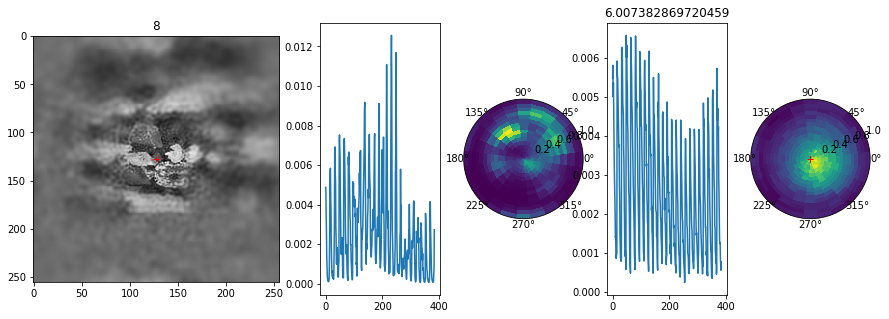

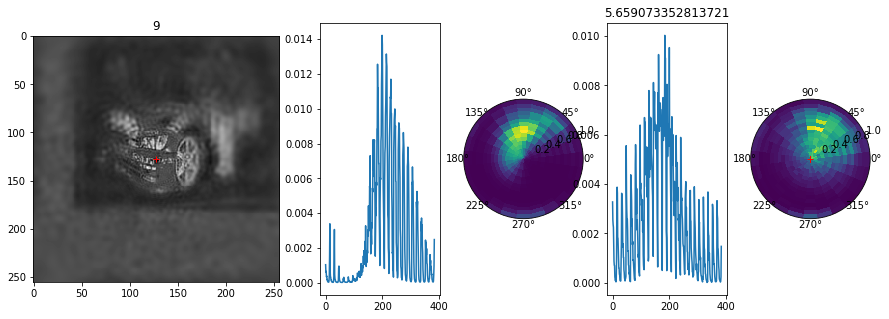

In [91]:
FIC_NAME = 'results/2018-12-10-Malek-recap-kernel-3-multi-1-nhidden1-500-gpu'
index = np.load(FIC_NAME+'-index.npy')
index_test = index[800:] 
net = torch.load(FIC_NAME+'.npy', map_location=lambda storage, loc: storage) #torch.load(FIC_NAME+'.npy').to('cpu') 

transform_test = Transform(test = True, tensor = True) 
test_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform_test, index = index_test)
test_loader = data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=4)

batch = next(iter(test_loader))
#batch = next(iter(train_loader))
for _ in range(10):
    
    image = colliculus_inverse @ batch['image'][_,:].reshape(N_azimuth * N_eccentricity)
    data_white = batch['image_white'][_,:,1:N_theta+1,:,:]
    data_white = np.transpose(data_white, (1, 2, 3, 0))
    image_white = retina_inverse @ data_white.reshape(N_theta * N_azimuth * N_eccentricity * N_phase)
    plt.figure(figsize = (15, 5))
    
    #plt.subplot(161)
    #plt.plot(batch['image_white'][_,:])
    plt.subplot(131)
    plt.imshow(image_white.reshape(N_X, N_X) * 20 + image.reshape(N_X, N_X) , cmap = 'gray')
    plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')
    plt.title(_)
    plt.subplot(163)
    plt.plot(batch['fixation'][_,:])    
    #col = colliculus_inverse @ batch['fixation'][_,:]
    ax = plt.subplot(164, projection='polar')
    vec = batch['fixation'][_,:]
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_ = batch['image'][_,:].reshape((1,1,N_azimuth,N_eccentricity)).float()
    in_white = batch['image_white'][_,:].reshape((1,N_phase,N_theta+2,N_azimuth,N_eccentricity)).float()
    out = net(in_, in_white)
    plt.subplot(165)
    out_sig = F.softmax(out).detach().numpy()
    plt.plot(out_sig[0,:]) #.detach().numpy()) #_sig)    
    loss = loss_func(out, vec.float()).detach().numpy()
    plt.title(loss)
    #view = colliculus_inverse @ out_sig
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0,'r+')
    #plt.imshow(view.reshape(128, 128))
                                 

In [82]:
fix = batch['fixation'].float().detach().numpy()

In [85]:
vec.shape

torch.Size([384])

In [87]:
vec.detach().numpy().sum()

0.99999999999999978